# 수화 이미지 RNN으로 분류하기

병준 part

0~9 숫자에 대응하는 수화 데이터 투입

숫자 사인 한 종류 당 1500장 이미지

한 이미지 당 50x50 픽셀

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from pathlib import Path

구글 드라이브에서 데이터셋 가져오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/rawimage.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# import pickle

# img_root = "/content/SL"
# labels = [f for f in os.listdir(img_root)]
# image_list = []
# label_list = []

# for label in labels:
#   folder_path = '{}{}{}'.format(img_root,'/',label)
#   for f in os.listdir(folder_path):
#     image_path = '{}{}{}'.format(folder_path,'/',f)
#     image_list.append(image_path)
#     label_list.append(label)
    
# print(len(image_list), len(label_list))
# df = pd.DataFrame({'img_path':image_list, 'class':label_list})
# df.head()
rand_num_list=rand_num_list = [random.sample([num for num in range(1,1501)], 345) for _ in range(0,10,1) ]
filepaths = []
for i in range(0,10,1):
    for j in range(0,300,1):
        filepaths.append(f"/content/rawimage/{i}/{rand_num_list[i][j]}.jpg")

def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='img_path').astype(str)
    labels = pd.Series(labels, name='class')

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths)
df.head(5)

,img_path,class
0,/content/rawimage/1/491.jpg,1
1,/content/rawimage/3/521.jpg,3
2,/content/rawimage/5/597.jpg,5
3,/content/rawimage/9/1214.jpg,9
4,/content/rawimage/9/1216.jpg,9


In [ ]:
#label의 타입이 str_이라 model.fit() 함수로 학습 시 오류 남. LabelEncoder()함수 이용하여 label을 str로 바꾸는 코드 추가
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['class'] = encoder.fit_transform(df['class'].astype('str'))

images = []
names = []
paths_and_classes = list(zip(df['img_path'].tolist(), df['class'])) # (사진경로, 라벨값) 형태의 df를 리스트로 저장

for path, label in paths_and_classes:
  img_tmp = cv2.imread(path, 1)
  
  #img = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2RGB) # BGR로 되어있는 이미지를 RGB로 바꿔준다.

  #RNN 모델이 3차원 컬러 이미지를 학습하지 못해서, 1차원 흑백 이미지로 변환
  # BGR로 되어있는 이미지를 흑백으로 바꿔준다.
  img = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2GRAY)
  images.append(img)
  names.append(path.split('/')[-1])


img_rgbs = np.array([image for image in images])
img_numbers = np.array([label for path, label in paths_and_classes])


np.savez('/content/rawimage/npz.npz', x = img_rgbs, y = img_numbers)

In [ ]:
data = np.load('/content/rawimage/npz.npz')
x = data['x']
y = data['y']

In [ ]:
print(x.shape)

(3000, 50, 50)


이제 X_train, X_test, y_train, y_test = train_test_split(x, y)을 활용해서 모델을 학습시킬 수 있다!

(2400, 50, 50) (600, 50, 50) (2400,) (600,)
<class 'numpy.int64'> 0


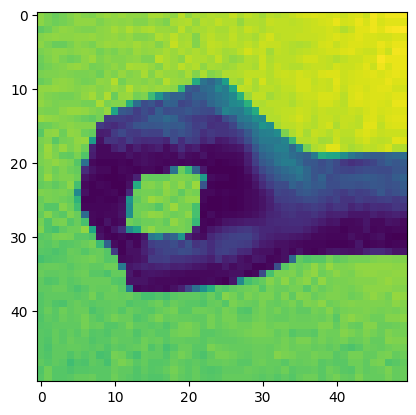

In [ ]:
from sklearn.model_selection import train_test_split
from PIL import Image

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=52)

# X는 이미지, Y는 label
X_train = X_train.reshape(-1,50,50)
X_test = X_test.reshape(-1,50,50)
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

print(X_train.shape, X_test.shape,Y_train.shape, Y_test.shape)
print(type(Y_train[0]), Y_train[0])
plt.imshow(X_train[0])

In [ ]:
# train : valid : test 비율 = 6 : 2 : 2
valid_ratio = 0.25

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=valid_ratio, random_state=123)

print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(1800, 50, 50) (1800,)
(600, 50, 50) (600,)
(600, 50, 50) (600,)


#RNN 모델

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential

model = tf.keras.Sequential([
  tf.keras.Input(shape=(50,50)),
  tf.keras.layers.SimpleRNN(128),
  tf.keras.layers.Dense(128, activation='relu',input_shape=(50, 50, )),
  tf.keras.layers.Dropout(0.2,input_shape=(128,)),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               22912     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 40,714
Trainable params: 40,714
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=20)

Epoch 1/20
57/57 [==============================] - 3s 27ms/step - loss: 1.8136 - accuracy: 0.3450 - val_loss: 1.1573 - val_accuracy: 0.6150
Epoch 2/20
57/57 [==============================] - 2s 34ms/step - loss: 1.0024 - accuracy: 0.6267 - val_loss: 0.7786 - val_accuracy: 0.7400
Epoch 3/20
57/57 [==============================] - 2s 36ms/step - loss: 0.7129 - accuracy: 0.7406 - val_loss: 0.5972 - val_accuracy: 0.7650
Epoch 4/20
57/57 [==============================] - 1s 26ms/step - loss: 0.5979 - accuracy: 0.7833 - val_loss: 0.4405 - val_accuracy: 0.8533
Epoch 5/20
57/57 [==============================] - 1s 22ms/step - loss: 0.4839 - accuracy: 0.8250 - val_loss: 0.7979 - val_accuracy: 0.7217
Epoch 6/20
57/57 [==============================] - 1s 22ms/step - loss: 0.4409 - accuracy: 0.8506 - val_loss: 0.3840 - val_accuracy: 0.8733
Epoch 7/20
57/57 [==============================] - 1s 22ms/step - loss: 0.3477 - accuracy: 0.8828 - val_loss: 0.5542 - val_accuracy: 0.8233
Epoch 8/20
57

<Figure size 640x480 with 0 Axes>

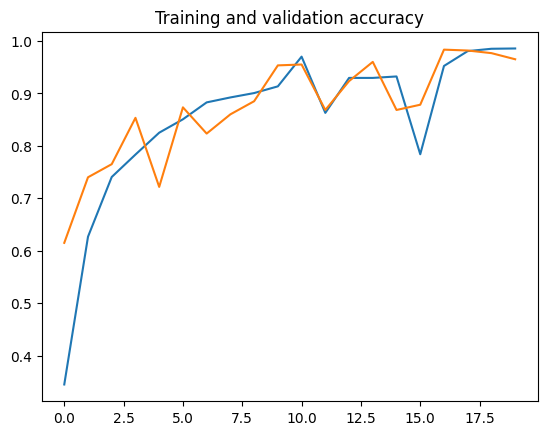

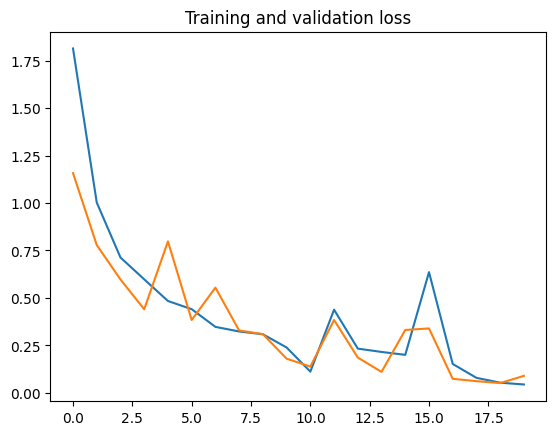

<Figure size 640x480 with 0 Axes>

In [ ]:
%matplotlib inline

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and validation loss')
plt.figure()

In [ ]:
#test accuracy
loss, acc = model.evaluate(X_test, Y_test, batch_size=32)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

19/19 [==============================] - 0s 7ms/step - loss: 0.0916 - accuracy: 0.9683

Test accuracy: 96.8%


#샘플 이미지를 학습된 모델에 넣기

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 1323.jpg to 1323.jpg


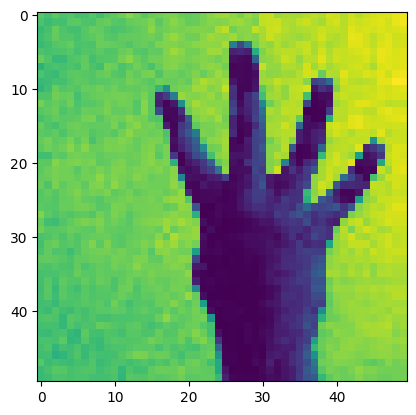

In [ ]:
from tensorflow.keras.preprocessing import image

img_path = "/content/1323.jpg"

test_image = image.load_img(img_path, target_size = (50,50))
test_image = image.img_to_array(test_image)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
#test_image = test_image.reshape(-1,50,50)
test_image = test_image.astype('float32')/255.0
plt.imshow(test_image);

test_image = (np.expand_dims(test_image,0))
#print(test_image.shape)

In [ ]:
prediction = model.predict(test_image)
print(np.argmax(prediction[0]))

df = pd.DataFrame({'pred':prediction[0]})
df = df.sort_values(by='pred', ascending=False, na_position='first')
print(f"## prediction : {(df.iloc[0]['pred'])* 100:.2f}%")

1/1 [==============================] - 0s 193ms/step
4
## prediction : 99.50%


bruteforce 숫자별 정확도 구하기(상협 ver)

In [ ]:
from tensorflow.keras.preprocessing import image

test_result =[]

for i in range(0,10,1):
    correct_count = 0
    for j in range(300,345,1):
        img_path = (f"/content/rawimage/{i}/{rand_num_list[i][j]}.jpg")


        test_image = image.load_img(img_path, target_size = (50,50))
        test_image = image.img_to_array(test_image)
        test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
        #test_image = test_image.reshape(-1,50,50)
        test_image = test_image.astype('float32')/255.0

        test_image = (np.expand_dims(test_image,0))
        #print(test_image.shape)
        prediction = model.predict(test_image)
        print(np.argmax(prediction[0]))
        if np.argmax(prediction[0])== i:
          print("Correct")
          correct_count+=1

    print("==================================================================================================")
    print(f"Number{i}= {correct_count} correct")
    test_result.append(correct_count)
    print("==================================================================================================")

print("========================================")
for i in range(0,10,1):
    print(f"num of correct: #{i} : {test_result[i]}, accuracy: {round((test_result[i]/0.45),2)}%")
print("========================================")

1/1 [==============================] - 0s 27ms/step
0
Correct
1/1 [==============================] - 0s 24ms/step
0
Correct
1/1 [==============================] - 0s 25ms/step
0
Correct
1/1 [==============================] - 0s 26ms/step
0
Correct
1/1 [==============================] - 0s 21ms/step
0
Correct
1/1 [==============================] - 0s 25ms/step
0
Correct
1/1 [==============================] - 0s 28ms/step
0
Correct
1/1 [==============================] - 0s 25ms/step
0
Correct
1/1 [==============================] - 0s 29ms/step
0
Correct
1/1 [==============================] - 0s 31ms/step
0
Correct
1/1 [==============================] - 0s 31ms/step
0
Correct
1/1 [==============================] - 0s 24ms/step
0
Correct
1/1 [==============================] - 0s 29ms/step
0
Correct
1/1 [==============================] - 0s 22ms/step
0
Correct
1/1 [==============================] - 0s 30ms/step
0
Correct
1/1 [==============================] - 0s 28ms/step
0
Correct
1/1 [===

# 번외) 인간 표정 데이터셋 사용

수화 데이터셋보다 훨씬 복잡한 유형의 이미지

image classification에 적합한 CNN이 아닌, RNN으로 학습한다면 어떤 결과가 나올지 실험해보기로 함

사람의 얼굴 표정 이미지가 담긴 데이터셋 사용

48x48 흑백 png 사진 28709장

angry(3995), happy(7215), fearful(4097), neutral(4965), sad(4830), surprised(3171)의 항목으로 구성되어 있음

disgusted(436) 항목은 이미지 개수가 적어서 학습에 제외

각 label 당 2000장의 랜덤한 이미지를 추출하여 학습에 사용

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from google.colab.patches import cv2_imshow

from pathlib import Path

구글 드라이브에서 데이터셋 가져오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/emotions.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()


In [ ]:

# rand_num_list=rand_num_list = [random.sample([num for num in range(1,1501)], 345) for _ in range(0,10,1) ]
# filepaths = []
# for i in range(0,10,1):
#     for j in range(0,300,1):
#         filepaths.append(f"/content/rawimage/{i}/{rand_num_list[i][j]}.jpg")

# def proc_img(filepath):
#     """
#    		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
#     """

#     labels = [str(filepath[i]).split("/")[-2] \
#               for i in range(len(filepath))]

#     filepath = pd.Series(filepath, name='img_path').astype(str)
#     labels = pd.Series(labels, name='class')

#     # 경로와 라벨 concatenate
#     df = pd.concat([filepath, labels], axis=1)

#     # index 재설정
#     df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
#     return df

# df = proc_img(filepaths)
# df.head(5)
rand_num_list=rand_num_list = [random.sample([num for num in range(0,3000)], 2502) for _ in range(0,7,1) ]
filepaths = []
label = []
emotion_words = ["angry"," disgusted", "fearful", "happy", "neutral", "sad", "surprised"] 
for i in range(0,7,1):
    if i !=1:
      for j in range(0,2500,1):
          filepaths.append(f"/content/emotions/{emotion_words[i]}/im{rand_num_list[i][j]}.png")
          label.append(str(i))
#rand_num_list[i][j]
def proc_img(filepath, labels):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    filepath = pd.Series(filepath, name='img_path').astype(str)
    labels = pd.Series(labels, name='class').astype(str)

    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(filepaths, label)
df.head(100)

,img_path,class
0,/content/emotions/angry/im86.png,0
1,/content/emotions/surprised/im871.png,6
2,/content/emotions/sad/im558.png,5
3,/content/emotions/fearful/im366.png,2
4,/content/emotions/happy/im2458.png,3
...,...,...
95,/content/emotions/fearful/im1522.png,2
96,/content/emotions/sad/im2040.png,5
97,/content/emotions/surprised/im1638.png,6
98,/content/emotions/angry/im2131.png,0


In [ ]:
#label의 타입이 str_이라 model.fit() 함수로 학습 시 오류 남. LabelEncoder()함수 이용하여 label을 str로 바꾸는 코드 추가
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['class'] = encoder.fit_transform(df['class'].astype('str'))

images = []
names = []
paths_and_classes = list(zip(df['img_path'].tolist(), df['class'])) # (사진경로, 라벨값) 형태의 df를 리스트로 저장

for path, label in paths_and_classes:
  img_tmp = cv2.imread(path, 1)
  
  #img = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2RGB) # BGR로 되어있는 이미지를 RGB로 바꿔준다.

  #RNN 모델이 3차원 컬러 이미지를 학습하지 못해서, 1차원 흑백 이미지로 변환
  # BGR로 되어있는 이미지를 흑백으로 바꿔준다.
  # img = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2GRAY)
  images.append(img)
  names.append(path.split('/')[-1])


img_rgbs = np.array([image for image in images])
img_numbers = np.array([label for path, label in paths_and_classes])


np.savez('/content/emotions/npz.npz', x = img_rgbs, y = img_numbers)

In [ ]:
data = np.load('/content/emotions/npz.npz')
x = data['x']
y = data['y']

In [ ]:
print(x.shape)

(15000, 48, 48)


이제 X_train, X_test, y_train, y_test = train_test_split(x, y)을 활용해서 모델을 학습시킬 수 있다!

(12000, 48, 48) (3000, 48, 48) (12000,) (3000,)
<class 'numpy.int64'> 1


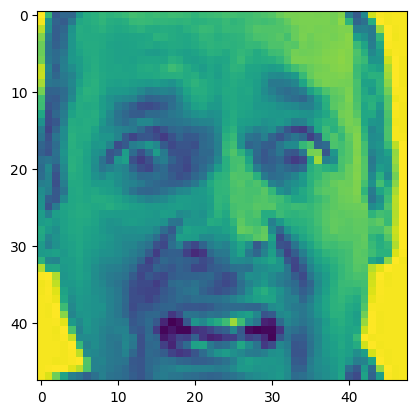

In [ ]:
from sklearn.model_selection import train_test_split
from PIL import Image

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=52)

# X는 이미지, Y는 label
X_train = X_train.reshape(-1,48,48)
X_test = X_test.reshape(-1,48,48)
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

print(X_train.shape, X_test.shape,Y_train.shape, Y_test.shape)
print(type(Y_train[0]), Y_train[0])
plt.imshow(X_train[0])

In [ ]:
# train : valid : test 비율 = 6 : 2 : 2
valid_ratio = 0.25

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=valid_ratio, random_state=123)

print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(9000, 48, 48) (9000,)
(3000, 48, 48) (3000,)
(3000, 48, 48) (3000,)


RNN 모델을 이용한 학습

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential

model = tf.keras.Sequential([
  tf.keras.Input(shape=(48,48)),
  tf.keras.layers.SimpleRNN(128),
  tf.keras.layers.Dense(128, activation='relu',input_shape=(48, 48, )),
  tf.keras.layers.Dropout(0.2,input_shape=(128,)),
  tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 128)               22656     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 39,942
Trainable params: 39,942
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=20)

Epoch 1/20
282/282 [==============================] - 7s 20ms/step - loss: 1.7758 - accuracy: 0.2173 - val_loss: 1.7242 - val_accuracy: 0.2550
Epoch 2/20
282/282 [==============================] - 7s 24ms/step - loss: 1.7330 - accuracy: 0.2476 - val_loss: 1.6971 - val_accuracy: 0.2687
Epoch 3/20
282/282 [==============================] - 5s 19ms/step - loss: 1.7128 - accuracy: 0.2624 - val_loss: 1.7089 - val_accuracy: 0.2617
Epoch 4/20
282/282 [==============================] - 7s 24ms/step - loss: 1.6950 - accuracy: 0.2737 - val_loss: 1.7052 - val_accuracy: 0.2687
Epoch 5/20
282/282 [==============================] - 5s 18ms/step - loss: 1.7422 - accuracy: 0.2480 - val_loss: 1.7230 - val_accuracy: 0.2500
Epoch 6/20
282/282 [==============================] - 5s 18ms/step - loss: 1.7264 - accuracy: 0.2494 - val_loss: 1.7706 - val_accuracy: 0.2233
Epoch 7/20
282/282 [==============================] - 7s 25ms/step - loss: 1.7179 - accuracy: 0.2574 - val_loss: 1.6972 - val_accuracy: 0.2787

<Figure size 640x480 with 0 Axes>

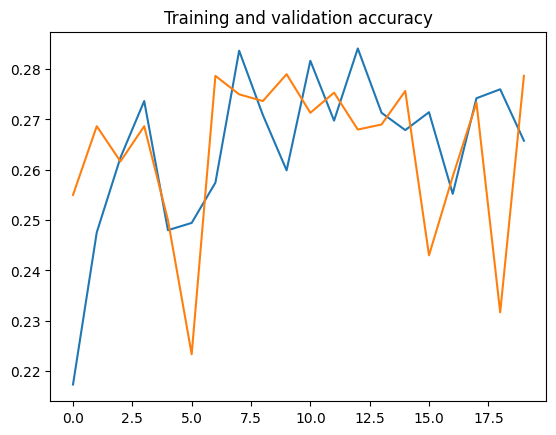

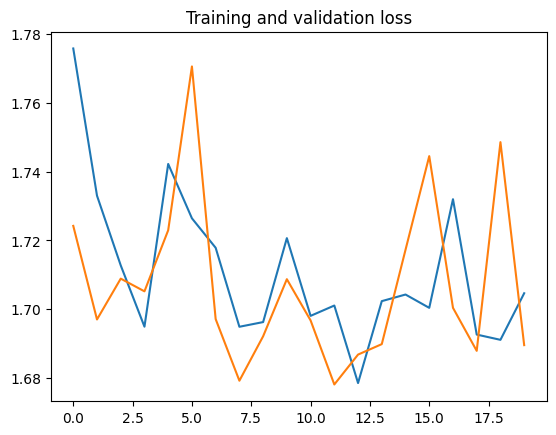

<Figure size 640x480 with 0 Axes>

In [ ]:
%matplotlib inline

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and validation loss')
plt.figure()

In [ ]:
#test accuracy
loss, acc = model.evaluate(X_test, Y_test, batch_size=32)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

94/94 [==============================] - 1s 8ms/step - loss: 1.7037 - accuracy: 0.2717

Test accuracy: 27.2%
